# Gutzwiller state on a quantum computer

Here I use a simillar approach as the last Gutzwiller notebook, 'Gutzwiller_in_kspace', except that I will use the measurment scheme which grows only linearly with system size.  Instead of breaking the operators into Pauli matrices, I keep the exponentials of Pauli operators as well.  This measurement techinque is explored in detail in the notebook 'Measuring Gutzwiller'.

# Initialize operators and fucntion

Below I define the identiry operator $I$, the Pauli operators $X$, $Y$, and $Z$, fermion creations and analiation operators $c^{\dagger}$, $c$, the fermion number operator $n=c^{\dagger}c$, and the k-space fermion operators $$ a^{\dagger} = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}e^{i\frac{2\pi n}{N}j}c^{\dagger}_j $$
and $a = (a^{\dagger})^{\dagger}$ where $N$ is the number of sites in the system.

I also define a function Mdot to take the dot product of multiple operators and btk to take brakets of operators.

In [1]:
import qiskit.quantum_info as qi
import scipy as sp
import numpy as np
import pandas as pd
import math
import scipy.linalg as ln

def I(N):
    label = ['I' for i in range(N)]
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def X(i,N):
    label = ['I' for i in range(N)]
    label[N-1-i] = 'X'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Y(i,N):
    label = ['I' for i in range(N)]
    label[N-1-i] = 'Y'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Z(i,N):
    label = ['I' for i in range(N)]
    label[N-1-i] = 'Z'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def c(i,N):
    label_1 = ['Z' for j in range(N-i-1)]
    label_2 = ['I' for j in range(N-i,N)]
    label_x = label_1 + ['X'] + label_2
    label_y = label_1 + ['Y'] + label_2
    label_x = ''.join(label_x)
    label_y = ''.join(label_y)
    x = qi.Operator.from_label(label_x).data
    y = qi.Operator.from_label(label_y).data
    return 1/2*(x+1j*y)

def cd(i,N):
    label_1 = ['Z' for j in range(N-i-1)]
    label_2 = ['I' for j in range(N-i,N)]
    label_x = label_1 + ['X'] + label_2
    label_y = label_1 + ['Y'] + label_2
    label_x = ''.join(label_x)
    label_y = ''.join(label_y)
    x = qi.Operator.from_label(label_x).data
    y = qi.Operator.from_label(label_y).data
    return 1/2*(x-1j*y)

def n(i,N):
    return Mdot([cd(i,N),c(i,N)])

def ad(n,N):
    out = cd(0,N)
    for i in range(1,N):
        out = out + np.exp(1j*2*np.pi*n*i/N)*cd(i,N)
    return 1/np.sqrt(N)*out

def a(n,N):
    out = c(0,N)
    for i in range(1,N):
        out = out + np.exp(-1j*2*np.pi*n*i/N)*c(i,N)
    return 1/np.sqrt(N)*out

import numpy as np


def Mdot(Ol):
    L = len(Ol)
    out = Ol[L-1]
    for i in range(1,len(Ol)):
        out = np.dot(Ol[L-1-i],out)
    return out

def bkt(y1,O,y2):
    return Mdot([np.conjugate(y1),O,y2])

# Define the system

The system is defined by its Hemiltonian which is composed of two parts.  A Kinetic term
$$ \hat{K} = k \sum_{i\sigma} \left( c^{\dagger}_{i\sigma}c_{i+1\sigma} + c^{\dagger}_{i+1\sigma}c_{i\sigma} \right)$$
and an interaction term
$$ \hat{D} = \sum_i \hat{n}_{i,\uparrow}\hat{n}_{i,\downarrow}.  $$

I also define the Gutzwiler operator,
$$ \hat{G} = \prod_{i=0}^{N-1}e^{-g n_{i\uparrow}n_{i\downarrow}} = \prod_{i=0}^{N-1} (1 - n_{i\uparrow}n_{i\downarrow} (e^{-g}-1) ), $$
and the lowest energy two partcle eigenstate of $\hat{K}$
$$ |\psi_1> = a^{\dagger}_0a^{\dagger}_1|0>. $$
and 
$$ |\psi_{\text{spin}}> = |\psi_1>\otimes|\psi_1> $$
such that $\hat{K}|\psi_{\text{spin}}> = E_{01}|\psi_{\text{spin}}>$

In [2]:
def G(g,N):
    out = I(2*N)
    for i in range(N):
        out = Mdot([ out , I(2*N) + (np.exp(-g)-1)*Mdot([n(i,2*N),n(i+N,2*N)]) ])
    return out

def K(k,N):
    Kout = 0*I(2*N)
    for i in range(0,N-1):
        Kout = Kout + Mdot([cd(i,2*N),c(i+1,2*N)]) + Mdot([cd(i+1,2*N),c(i,2*N)])
        Kout = Kout + Mdot([cd(i+N,2*N),c(i+1+N,2*N)]) + Mdot([cd(i+1+N,2*N),c(i+N,2*N)])
    Kout = Kout + Mdot([cd(0,2*N),c(N-1,2*N)]) + Mdot([cd(N-1,2*N),c(0,2*N)])
    Kout = Kout + Mdot([cd(0+N,2*N),c(N-1+N,2*N)]) + Mdot([cd(N-1+N,2*N),c(0+N,2*N)])
    return k*Kout

def D(d,N):
    Dout = 0*I(2*N)
    for i in range(0,N):
        Dout = Dout + Mdot([n(i,2*N),n(i+N,2*N)])
    return d*Dout

def psi0(N):
    y = [0 for i in range(2**N)]
    y[0] = 1
    return y

psi1 = Mdot([ad(3,4),ad(2,4),psi0(4)])
psi_spin = np.kron(psi1,psi1)

In [3]:
k=1.3
np.amax(np.abs( Mdot([K(k,4),psi_spin]) - Mdot([np.conjugate(psi_spin),K(k,4),psi_spin])*psi_spin ))

3.510833468576701e-16

# Defining the circuit representation of the slatter determinent

This is described in detail in 'Gutzwiller_In_KSpace'.

First we need the transformation function $f$ such that 
$$ a^{\dagger}_n = \sum_i f_{in} c^{\dagger}_i $$
or if we groupd the creation operators into a vector 
$$ \vec{a}^{\dagger} = \hat{F} \vec{c}^{\dagger} $$

In [4]:
def f(i,n,N):
    return np.sqrt(1/(N))*np.exp(1j*2*np.pi*(i)*(n)/N)

def F(N): 
    return np.array([[f(i,n,N) for i in range(N)] for n in range(N)])

The stratagy is then to find rotations which diagonalize $\hat{F}$ then we can apply the reverse rotations to create $\hat{F}$ on the quantum computer.  I should make it clear that we are talking about two different spaces.  The single particle space where $\hat{F}$ acts and the manybody space in which the quantum computer lives.  Since the state we want to create has a representation in both spaces, we can map between them.  We will do the following rotations in the single particle space,

$$ (r^y_{ij}(\phi))_{kl} = \cos(\phi)\delta_{ik}\delta_{il}+\cos(\phi)\delta_{jk}\delta_{jl} + \sin(\phi)\delta_{ik}\delta_{jl} - \sin(\phi)\delta_{jk}\delta_{il}$$
and 
$$ (r^z_j(\phi))_{kl} = e^{i\phi}\delta_{ik}\delta_{kl} $$

these are combined the 'givens' function below.  We preform the a number of givens rotations until $\hat{F}$ is diagonalized.  This gives us the correct angles for the rotations.  Then we map these rotations to the manybody space.  $r^z$ maps simply to and $R^z$ rotation in the many body space while $r^y$ maps to the function $R_{cc}$ defined below. 
$$ r^z \rightarrow R^z $$
$$ r^y \rightarrow R_{cc}$$

$G_{cc}$ combines both manybody rotations and 'fswap' is a fermion swap which is nececcary for $R_{cc}$

In [5]:
def ry(i,j,phi,N):
    M = (1+0*1j)*np.identity(N)
    M[i,i] = np.cos(phi)
    M[j,j] = np.cos(phi)
    M[i,j] = np.sin(phi)
    M[j,i] = -np.sin(phi)
    return M


def rz(j,phi,N):
    M = (1+0*1j)*np.identity(N)
    M[j,j] = np.exp(1j*phi)
    return M

def givens(i,j,F):
    phiz = 1j*np.log( F[j,i]/F[i,i] * np.abs(F[i,i])/np.abs(F[j,i]) )
    Fz =  Mdot([rz(j,phiz,4) , F])
    phi = np.arctan(Fz[j,i]/Fz[i,i])
    F_new = Mdot([ry(i,j,phi,4) , Fz])
    return F_new,phiz,phi

from qiskit import QuantumCircuit

def fswap(i,j,qc):
    qc.swap(i,j)
    qc.ry(np.pi/2,j)
    qc.cx(i,j)
    qc.ry(-np.pi/2,j)
    return qc
    

def R_cc(i,j,phi,qc):
    for l in range(i+1,j):
        qc = fswap(l-1,l,qc)
    qc.ry(-np.pi/2,j-1)
    qc.cx(j-1,j)
    qc.ry(-phi,j)
    qc.cx(j-1,j)
    qc.ry(np.pi/2,j-1)
    qc.ry(-np.pi/2,j)
    qc.cx(j,j-1)
    qc.ry(phi,j-1)
    qc.cx(j,j-1)
    qc.ry(np.pi/2,j)
    for l in range(j-1,i+1-1,-1):
        qc = fswap(l-1,l,qc)
    return qc

def G_cc(i,j,phi,phiz,qc):
    qc = R_cc(i,j,-phi,qc)
    qc.rz(-phiz,j)
    return qc


All of the steps described above are combined into a single function called 'slatter_circ' which creates the circuit which maps the slatter determinent onto the quantum computer. 

In [6]:
from qiskit import QuantumCircuit, transpile, QuantumRegister,ClassicalRegister, execute

def slatter_circ(F):
    F1,pz1,p1 = givens(0,3,F)
    F2,pz2,p2 = givens(0,2,F1)
    F3,pz3,p3 = givens(0,1,F2)
    F4,pz4,p4 = givens(1,3,F3)
    F5,pz5,p5 = givens(1,2,F4)
    F6,pz6,p6 = givens(2,3,F5)
    ph0 = -1j*np.log(F6[0,0])
    ph1 = -1j*np.log(F6[1,1])
    ph2 = -1j*np.log(F6[2,2])
    ph3 = -1j*np.log(F6[3,3])
    qr = QuantumRegister(4)
    cr = ClassicalRegister(4)
    qc = QuantumCircuit(qr , cr)
    qc.x(2)
    qc.x(3)
    qc.rz(np.real(ph0),0)
    qc.rz(np.real(ph1),1)
    qc.rz(np.real(ph2),2)
    qc.rz(np.real(ph3),3)
    qc = G_cc(2,3,np.real(p6),np.real(pz6),qc)
    qc = G_cc(1,2,np.real(p5),np.real(pz5),qc)
    qc = G_cc(1,3,np.real(p4),np.real(pz4),qc)
    qc = G_cc(0,1,np.real(p3),np.real(pz3),qc)
    qc = G_cc(0,2,np.real(p2),np.real(pz2),qc)
    qc = G_cc(0,3,np.real(p1),np.real(pz1),qc)
    return qc



In [7]:
#Test
F1,pz1,p1 = givens(0,3,F(4))
F2,pz2,p2 = givens(0,2,F1)
F3,pz3,p3 = givens(0,1,F2)
F4,pz4,p4 = givens(1,3,F3)
F5,pz5,p5 = givens(1,2,F4)
F6,pz6,p6 = givens(2,3,F5)
ph0 = -1j*np.log(F6[0,0])
ph1 = -1j*np.log(F6[1,1])
ph2 = -1j*np.log(F6[2,2])
ph3 = -1j*np.log(F6[3,3])

qc = slatter_circ(F(4))
psi_tst = qi.Statevector.from_instruction(qc).data
phase = np.exp(-1j*ph0/2)*np.exp(-1j*ph1/2)*np.exp(-1j*ph2/2)*np.exp(-1j*ph3/2)
phase = phase*np.exp(1j*pz6/2)*np.exp(1j*pz5/2)*np.exp(1j*pz4/2)*np.exp(1j*pz3/2)*np.exp(1j*pz2/2)*np.exp(1j*pz1/2)
psi1 = Mdot([ad(3,4),ad(2,4),psi0(4)])
np.amax(np.abs( psi_tst - phase*psi1 ))

2.187358838057016e-16

# Running the circuits

We will start by defining the standard functions for altering circuits to measure specific Pauli matrics.  These are 'create_circ' and 'create_circs'.  

The Pauli strings we will need to measure are defined in 'paulis'.  The reason we need these specific Pauli strings be discussed when I talk about analyzing the results.

'circs' holds the circuits we will run.

In [8]:
import copy 

def create_circ(p_label):
    qbits = [0,1,2,3]
    qc = slatter_circ(F(4))
    psi = copy.deepcopy(qc)
    pauli_qs = []
    Z_label = ''
    Q = len(p_label)-1
    for q,p in enumerate(p_label):
        if p == 'X':
            psi.ry(-np.pi/2,qbits[Q-q])
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Y':
            psi.rx(np.pi/2,qbits[Q-q])
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Z':
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'I':
            pauli_qs.append(0)
            Z_label += 'I'
    psi.measure(psi.qubits,psi.clbits)
    return [psi,pauli_qs,p_label]

def create_circs(paulis):
    circs = []
    for p_label in paulis:
        circ, pauli_qs, labels = create_circ(p_label)
        circs.append(circ)
    return circs

paulis = ['ZZZZ','XXZZ','YYZZ','ZXXZ','ZYYZ','ZZXX','ZZYY','XZZX','YZZY']

circs = create_circs(paulis)


We are doing spin down on the quantum computer and spin up classically.  Therefore, we need weights for each spin up state.  Since the full state is simply $|\psi_0>\otimes|\psi_0>$ we can pull these weights directely out of $|\psi_0>$.  'alphas' holds these weights. 

In [9]:
def alphas(N):
    psi1 = Mdot([ad(3,N),ad(2,N),psi0(N)])
    psi_new = -1j*psi1/psi1[3]
    norm = Mdot([np.conjugate(psi_new),psi_new])
    return psi_new/np.sqrt(norm)


Before we run the circuits we need to load an account and get a backend.

In [10]:
from qiskit import IBMQ,transpile
from qiskit.tools.monitor import job_monitor
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-afrl', group='air-force-lab', project='quantum-sim')
#backend = provider.get_backend('ibmq_jakarta')
backend = provider.get_backend('ibm_lagos')

The 'get_results' function has three methods for finding the results.

'matrix' $\rightarrow$ exact solution using matrix multiplication

'simulator' $\rightarrow$ approximate solution using the qasm simulator

'quantum' $\rightarrow$ using the quantum backend we loaed above.

The results are held in 'results'

In [12]:
from qiskit import Aer
import copy

def get_results(circs_in, method = 'matrix',save_id_file = None):
    circs = copy.deepcopy(circs_in)
    #Exact Calculation
    if method == 'matrix':
        # add results
        r = []
        for l in range(len(circs)):
            circs[l].remove_final_measurements()
            wave = qi.Statevector.from_instruction(circs[l])
            r_l = wave.probabilities_dict()
            r.append(r_l)
    #Qiskit Simulation        
    if method == "simulator":
        sim = Aer.get_backend("qasm_simulator")
        r = execute(circs, backend = sim).result().get_counts() 
    #Device
    if method == "quantum":
        job = backend.run(transpile(circs, backend), meas_level=2, shots=8192)
        job_id = job.job_id()
        print(job_id)
        np.save(save_id_file,[job_id])
        r = job.result().get_counts()
    return r

results = get_results(circs)
#results = get_results(circs, method = 'simulator')

#save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/Gutzwiller/Data/Job_id_test3"
#results = get_results(circs, method = 'quantum',save_id_file = save_id_file)

# Analyzing the results

We want to calculate 
$$E(g) = \frac{<\psi_0|\hat{G}\hat{H}\hat{G}|\psi_0>}{ <\psi_0|\hat{G}\hat{G}|\psi_0>  }$$
where $|\psi_0>$ is the slatter state which we have measured.  

In order to use the measurements we have taken to calculate $E(g)$ we will need to reference the spin up states and their weights.  The following three functions 'bi', 'up_states', and 'up_states_dic' help to reference the spin up states.

In [13]:
def bi(num,N):
    bi = bin(num)
    out = ""
    for i in range(2,len(bi)):
        out = out + bi[i]
    L = len(out)
    for i in range(L,N):
        out = "0"+out
    return out

def up_states(N):
    out = []
    a = alphas(N)
    for i in range(2**N):
        out.append([bi(i,N),a[i]])
    return out

def up_states_dic(N):
    out = {}
    a = alphas(N)
    for i in range(2**N):
        out[bi(i,N)] = a[i]
    return out



Now we are ready to discuss how to analyze the results.  We need three brakets to calculate $E(g)$,
$$ <\psi_0|\hat{G}\hat{G}|\psi_0>, \quad <\psi_0|\hat{G}\hat{D}\hat{{G}}|\psi_0>, \quad <\psi_0|\hat{G}\hat{K}\hat{{G}}|\psi_0>. $$

The first two only require the measurement labeled 'ZZZZ' in 'paulis'.  In order to get these two brakets we simple need to check if the spin-up state and spin-down state have are both on for each index, result state, and spin-up state.  Let us refere to this value as $m_{irk}$ which is 1 if the spin-up state $k$ and the result state $r$ are both on at index $i$ and 0 otherwise.  

The normalization braket is
$$ <\psi_0|\hat{G}\hat{G}|\psi_0> = \sum_k |\alpha_k|^2\sum_r w_r \prod_i e^{-2m_{irk}g} $$

The second bracket is 
$$ <\psi_0|\hat{G}\hat{D}\hat{G}|\psi_0> = \sum_k |\alpha_k|^2\sum_r w_r \sum_p m_{prk}\prod_i e^{-2m_{irk}g} $$

The functions 'analyze_GG' and 'analyze_GDG' represent these two brakets.

where $w_r$ is the results for state $r$ and $\alpha_k$ is the weight of state $k$.

The third bracket requires all of the results.  The braket can be inferd from the result
$$ \hat{G}\hat{K}\hat{G} = \sum_{i=0}^{N-1}\sum_{\sigma}\prod_{j \neq i,i+1}e^{-2g n_{j\uparrow}n_{j\downarrow}} e^{-g n_{i\sigma+1}}e^{-g n_{i+1\sigma+1}}  \frac{k}{2}\left(X_{i\sigma}X_{i+1\sigma}+Y_{i+1\sigma}Y_{i\sigma}\right) $$

and the exact form of the braket is define below.  First we take the braket of each pauli term.  The spin-up Paulis need to be treaed seperately from the spin-down Paulis*.  Also the boundary term Paulis are treated seperetely from the bulk terms.  Finally, the function 'analyze_GKG' sums it all together. 

*Note: that since the full state is $|\psi_0>\otimes|\psi_0>$ the spin-down results and spin up results are the same.  Futhermore, due to translational symmetary, we only really need to measure the paulis at on site.

In [14]:
def analyze_GG(g,N,result):
    psi_up = up_states(N)
    r_keys = list(result.keys())
    gg = 0
    for k in range(len(psi_up)):
        s = psi_up[k][0]
        a = psi_up[k][1]
        for sr in r_keys:
            w = result[sr]
            gg_sr = 1
            for i in range(N):
                nu = int(s[i])
                nd = int(sr[i])
                gg_sr = gg_sr*np.exp(-2*g*nu*nd)
            gg = gg + np.conjugate(a)*a*w*gg_sr
    return gg
    
    
def analyze_GDG(g,d,N,result):
    psi_up = up_states(N)
    r_keys = list(result.keys())
    gg = 0
    for p in range(N):
        for k in range(len(psi_up)):
            s = psi_up[k][0]
            a = psi_up[k][1]
            for sr in r_keys:
                w = result[sr]
                gg_sr = 1
                for i in range(N):
                    nu = int(s[i])
                    nd = int(sr[i])
                    gg_sr = gg_sr*np.exp(-2*g*nu*nd)
                nu_p = int(s[p])
                nd_p = int(sr[p])
                gg_sr = d*gg_sr*nu_p*nd_p
                gg = gg + np.conjugate(a)*a*w*gg_sr
    return gg


#################################################################################################


def analyze_XuXu(g,i,N,result):
    psi_up = up_states_dic(N)
    up_keys = list(psi_up.keys())
    r_keys = list(result.keys())
    gg = 0
    for su in up_keys:
        sup = list(su)
        sup[i] = str(np.mod(int(sup[i])+1,2) )
        sup[i+1] = str(np.mod(int(sup[i+1])+1,2) )
        sup = ''.join(sup)
        a = psi_up[su]
        aa = psi_up[sup]
        for sr in r_keys:
            w = result[sr]
            gg_sr = 1
            for j in range(N):
                nu = int(su[j])
                nd = int(sr[j])
                if j == i:
                    gg_sr = gg_sr*np.exp(-g*nd)
                elif j == i+1:
                    gg_sr = gg_sr*np.exp(-g*nd)
                else:
                    gg_sr = gg_sr*np.exp(-2*g*nu*nd)
            gg = gg + np.conjugate(aa)*a*w*gg_sr
    return gg

def analyze_YuYu(g,i,N,result):
    psi_up = up_states_dic(N)
    up_keys = list(psi_up.keys())
    r_keys = list(result.keys())
    gg = 0
    for su in up_keys:
        sup = list(su)
        sup[i] = str(np.mod(int(sup[i])+1,2) )
        sup[i+1] = str(np.mod(int(sup[i+1])+1,2) )
        sup = ''.join(sup)
        a = psi_up[su]
        aa = psi_up[sup]
        for sr in r_keys:
            w = result[sr]
            gg_sr = 1
            for j in range(N):
                nu = int(su[j])
                nd = int(sr[j])
                if j == i:
                    gg_sr = gg_sr*np.exp(-g*nd)
                elif j == i+1:
                    gg_sr = gg_sr*np.exp(-g*nd)
                else:
                    gg_sr = gg_sr*np.exp(-2*g*nu*nd)
            gg = gg + (-1)**int(su[i])*(-1)**int(su[i])*np.conjugate(aa)*a*w*gg_sr
    return gg
            
                
def analyze_XdXd(g,i,N,results):
    result = results[2*i+1]
    psi_up = up_states_dic(N)
    up_keys = list(psi_up.keys())
    r_keys = list(result.keys())
    gg = 0
    for su in up_keys:
        a = psi_up[su]
        for sr in r_keys:
            w = result[sr]
            gg_sr = 1
            z0 = (-1)**int(sr[i])
            z1 = (-1)**int(sr[i+1])
            gg_sr = gg_sr*z0*z1
            for j in range(N):
                nu = int(su[j])
                nd = int(sr[j])
                if j == i:
                    gg_sr = gg_sr*np.exp(-g*nu)
                elif j == i+1:
                    gg_sr = gg_sr*np.exp(-g*nu)
                else:
                    gg_sr = gg_sr*np.exp(-2*g*nu*nd)
            gg = gg + np.conjugate(a)*a*w*gg_sr
    return gg  

def analyze_YdYd(g,i,N,results):
    result = results[2*i+2]
    psi_up = up_states_dic(N)
    up_keys = list(psi_up.keys())
    r_keys = list(result.keys())
    gg = 0
    for su in up_keys:
        a = psi_up[su]
        for sr in r_keys:
            w = result[sr]
            gg_sr = 1
            z0 = (-1)**int(sr[i])
            z1 = (-1)**int(sr[i+1])
            gg_sr = gg_sr*z0*z1
            for j in range(N):
                nu = int(su[j])
                nd = int(sr[j])
                if j == i:
                    gg_sr = gg_sr*np.exp(-g*nu)
                elif j == i+1:
                    gg_sr = gg_sr*np.exp(-g*nu)
                else:
                    gg_sr = gg_sr*np.exp(-2*g*nu*nd)
            gg = gg + np.conjugate(a)*a*w*gg_sr
    return gg  
       
#################################################################################################


def analyze_XuZZXu(g,N,result):
    psi_up = up_states_dic(N)
    up_keys = list(psi_up.keys())
    r_keys = list(result.keys())
    gg = 0
    for su in up_keys:
        sup = list(su)
        sup[0] = str(np.mod(int(sup[0])+1,2) )
        sup[N-1] = str(np.mod(int(sup[N-1])+1,2) )
        sup = ''.join(sup)
        a = psi_up[su]
        aa = psi_up[sup]
        for sr in r_keys:
            w = result[sr]
            gg_sr = 1
            for j in range(N):
                nu = int(su[j])
                nd = int(sr[j])
                if j == 0:
                    gg_sr = gg_sr*np.exp(-g*nd)
                elif j == N-1:
                    gg_sr = gg_sr*np.exp(-g*nd)
                else:
                    gg_sr = (-1)**nu*gg_sr*np.exp(-2*g*nu*nd)
            gg = gg + np.conjugate(aa)*a*w*gg_sr
    return gg

def analyze_YuZZYu(g,N,result):    
    psi_up = up_states_dic(N)
    up_keys = list(psi_up.keys())
    r_keys = list(result.keys())
    gg = 0
    for su in up_keys:
        sup = list(su)
        sup[0] = str(np.mod(int(sup[0])+1,2) )
        sup[N-1] = str(np.mod(int(sup[N-1])+1,2) )
        sup = ''.join(sup)
        a = psi_up[su]
        aa = psi_up[sup]
        for sr in r_keys:
            w = result[sr]
            gg_sr = 1
            for j in range(N):
                nu = int(su[j])
                nd = int(sr[j])
                if j == 0:
                    gg_sr = gg_sr*np.exp(-g*nd)
                elif j == N-1:
                    gg_sr = gg_sr*np.exp(-g*nd)
                else:
                    gg_sr = (-1)**nu*gg_sr*np.exp(-2*g*nu*nd)
            gg = gg - (-1)**int(su[0])*(-1)**int(su[N-1])*np.conjugate(aa)*a*w*gg_sr   #the sign does not match YuYu
    return gg

def analyze_XdZZXd(g,N,results):
    result = results[2*N-1]
    psi_up = up_states_dic(N)
    up_keys = list(psi_up.keys())
    r_keys = list(result.keys())
    gg = 0
    for su in up_keys:
        a = psi_up[su]
        for sr in r_keys:
            w = result[sr]
            gg_sr = 1
            z0 = (-1)**int(sr[0])
            z1 = (-1)**int(sr[N-1])
            gg_sr = gg_sr*z0*z1
            for j in range(N):
                nu = int(su[j])
                nd = int(sr[j])
                if j == 0:
                    gg_sr = gg_sr*np.exp(-g*nu)
                elif j == N-1:
                    gg_sr = gg_sr*np.exp(-g*nu)
                else:
                    gg_sr = (-1)**nd*gg_sr*np.exp(-2*g*nu*nd)
            gg = gg + np.conjugate(a)*a*w*gg_sr
    return gg 

def analyze_YdZZYd(g,N,results):
    result = results[2*N]
    psi_up = up_states_dic(N)
    up_keys = list(psi_up.keys())
    r_keys = list(result.keys())
    gg = 0
    for su in up_keys:
        a = psi_up[su]
        for sr in r_keys:
            w = result[sr]
            gg_sr = 1
            z0 = (-1)**int(sr[0])
            z1 = (-1)**int(sr[N-1])
            gg_sr = gg_sr*z0*z1
            for j in range(N):
                nu = int(su[j])
                nd = int(sr[j])
                if j == 0:
                    gg_sr = gg_sr*np.exp(-g*nu)
                elif j == N-1:
                    gg_sr = gg_sr*np.exp(-g*nu)
                else:
                    gg_sr = (-1)**nd*gg_sr*np.exp(-2*g*nu*nd)
            gg = gg + np.conjugate(a)*a*w*gg_sr
    return gg 

       
########################################################################    

def analyze_GKG(g,k,N,results):
    gg = 0
    for i in range(N-1):
        gg = gg + k/2*analyze_XuXu(g,i,N,results[0])
        gg = gg + k/2*analyze_YuYu(g,i,N,results[0])
        gg = gg + k/2*analyze_XdXd(g,i,N,results)
        gg = gg + k/2*analyze_YdYd(g,i,N,results)
    gg = gg + k/2*analyze_XuZZXu(g,N,results[0])
    gg = gg + k/2*analyze_YuZZYu(g,N,results[0])
    gg = gg + k/2*analyze_XdZZXd(g,N,results)
    gg = gg + k/2*analyze_YdZZYd(g,N,results)
    return gg

In [15]:
print( analyze_YdZZYd(1.2,4,results) - Mdot([np.conjugate(psi_spin),G(1.2,4),Y(4,8),Z(5,8),Z(6,8),Y(7,8),G(1.2,4),psi_spin]) )
print( analyze_YdZZYd(1.2,4,results) - analyze_YuZZYu(1.2,4,results[0]) )    
print( analyze_GKG(1.3,2.1,4,results) -  Mdot([np.conjugate(psi_spin),G(1.3,4),K(2.1,4),G(1.3,4),psi_spin]) )    
print( analyze_GDG(1.3,2.1,4,results[0]) -  Mdot([np.conjugate(psi_spin),G(1.3,4),D(2.1,4),G(1.3,4),psi_spin]) )
print( analyze_GG(1.3,4,results[0]) - Mdot([np.conjugate(psi_spin),G(1.3,4),G(1.3,4),psi_spin]) )


(9.71445146547012e-17+0j)
(2.7755575615628914e-17+4.7704895589362195e-18j)
(6.661338147750939e-16-1.1263668621613283e-17j)
(-8.326672684688674e-17+1.5253209489518614e-18j)
(-1.3877787807814457e-16-7.915397324550411e-19j)


Now we can combine the results to get the energy.

In [16]:
def analyze_energy(g,k,d,N,results):
    num = analyze_GDG(g,d,N,results[0]) + analyze_GKG(g,k,N,results)
    dom = analyze_GG(g,N,results[0])
    return num/dom

# Running Scans

With everything in order we can now run scans of $E(g)$.

In [75]:
k = 1
d = 0
N=4
H = K(k,4) + D(d,4)
e,y = np.linalg.eig(H)
y = np.transpose(y)
arg = np.argsort(e)


eg = []
gl = []
eT = []
for gi in range(-10,10):
    g = gi
    egl = analyze_energy(g,k,d,N,results)
    eg.append(egl)
    gl.append(g)
    eT.append(e[arg[[1]]])

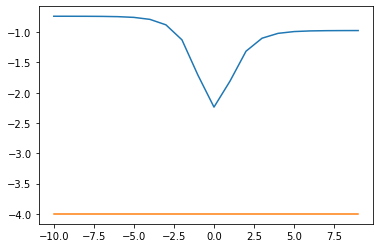

In [76]:
import matplotlib.pyplot as plt

plt.plot(gl,eg)
#plt.plot(gl,eg_h)
plt.plot(gl,eT)

# Save Results

In [81]:
import pickle
#fpath = "/Users/stenger/Documents/Research/Hubbard_symmetries/Gutzwiller/Data/"

#file_to_store = open(fpath + "Gutz3_lagos_test.pickle", "wb")

#pickle.dump(results, file_to_store)

# Load Results

In [17]:
import pickle
fpath = "/Users/stenger/Documents/Research/Hubbard_symmetries/Gutzwiller/Data/"

file_to_read = open(fpath + "Gutz3_lagos_test.pickle", "rb")

loaded_results = pickle.load(file_to_read)

In [47]:
k = 1
d = 10
N=4
H = K(k,4) + D(d,4)
e,y = np.linalg.eig(H)
y = np.transpose(y)
arg = np.argsort(e)


eg = []
gl = []
eT = []
for gi in range(-10,10):
    g = gi
    egl = analyze_energy(g,k,d,N,loaded_results)
    eg.append(egl)
    gl.append(g)
    eT.append(e[arg[[0]]])

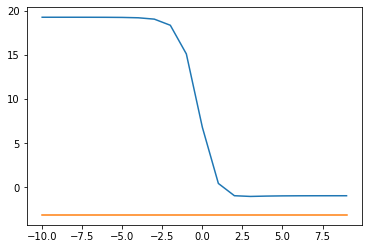

In [48]:
import matplotlib.pyplot as plt

plt.plot(gl,eg)
#plt.plot(gl,eg_h)
plt.plot(gl,eT)

# What I am ploting as E0 is the absolute ground state which is different in generel from the two particle ground state!

In [49]:
def num_d(N):
    out = 0*I(2*N)
    for i in range(N):
        out = out + n(i,2*N)
    return out

def num_u(N):
    out = 0*I(2*N)
    for i in range(N):
        out = out + n(i+N,2*N)
    return out


In [50]:
N=4
psi_2p = []
for i in range(0,2**(2*N)):
    psi_2pi = np.array( [0 for i in range(2**(2*N))] )
    psi_2pi[i] = 1
    check = bkt(psi_2pi,num_u(4),psi_2pi)
    if check == 2:
        psi_2p.append(psi_2pi)
psi_2p = np.array(psi_2p)

In [79]:
k = 1
d = 5
N=4
H = K(k,4) + D(d,4)
H_2p = Mdot([psi_2p,H,np.transpose(psi_2p)])
e2p,y2p = np.linalg.eig(H_2p)
y2p = np.transpose(y2p)
arg2p = np.argsort(e2p)


eg = []
egm = []
gl = []
eT = []
for gi in range(-100,101):
    g = 0.1*gi
    egl = analyze_energy(g,k,d,N,loaded_results)
    eglm = analyze_energy(g,k,d,N,results)
    eg.append(egl)
    egm.append(eglm)
    gl.append(g)
    eT.append(e2p[arg2p[[0]]])

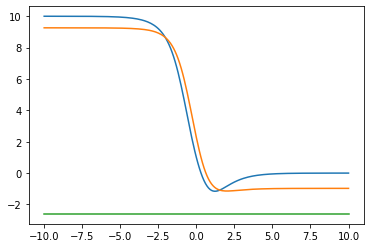

In [80]:
import matplotlib.pyplot as plt

plt.plot(gl,egm)
plt.plot(gl,eg)
plt.plot(gl,eT)

In [84]:
k = 1
eq = []
em = []
eh = []
dl = []
for di in range(0,100):
    d = di*0.2
    N=4
    H = K(k,4) + D(d,4)
    H_2p = Mdot([psi_2p,H,np.transpose(psi_2p)])
    e2p,y2p = np.linalg.eig(H_2p)
    y2p = np.transpose(y2p)
    arg2p = np.argsort(e2p)



    eg = []
    egm = []
    gl = []
    eT = []
    for gi in range(0,30):
        g = 0.1*gi
        egl = analyze_energy(g,k,d,N,loaded_results)
        eglm = analyze_energy(g,k,d,N,results)
        eg.append(egl)
        egm.append(eglm)
        gl.append(g)
        eT.append(e2p[arg2p[[0]]])
    #print(d,min(eT))
    eq.append(min(eg))
    em.append(min(egm))
    eh.append(min(eT))
    dl.append(d)

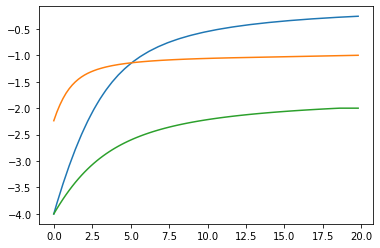

In [85]:
plt.plot(dl,em)
plt.plot(dl,eq)
plt.plot(dl,eh)